In [1]:
import os
import pandas as pd
import json
import csv
from pandas import json_normalize

In [121]:
# remove dump file every time this runs for testing purposes
try:
    os.remove('json_dump_file.csv')
    os.remove("final_output.csv")
except:
    pass

In [131]:
# get all json filenames into one list
file_list = []
directory = os.fsencode("timeseries_data_rawjson")

for file in os.listdir(directory):
    filename = str(os.fsdecode(file))
    if(filename != '.ipynb_checkpoints'):
        file_list.append(filename)

# script to scrape and dump all JSON files into a single CSV
output_df = pd.DataFrame(columns=['container_id','alert_triggered_time','serviced_time','pick_up_time_hrs','overflow'])
for i in file_list:
    js = """"""
    with open(f"timeseries_data_rawjson/%s" % i, 'r') as f:
        # load JSON raw data
        for line in f:
            js += line
        raw_json = json.loads(js)['data']
    print(len(raw_json['data']))
        
    # make dictionary for de-nesting json
    d_raw = pd.DataFrame(columns =['container_id', 'fill_level_percentage','timestamp'])

    # parse and de-nest needed fields
    for j in raw_json['data']:
        container_id = j['container_id']
        fill_level_percentage = j['fill_level_percentage']
        ts = j['timestamp']
        d_raw.loc[len(d_raw.index)] = [container_id, fill_level_percentage, ts]
    d_raw['timestamp'] = pd.to_datetime(d_raw['timestamp'])
    
    # sort values by timestamp
    df_tmp = d_raw.sort_values(by='timestamp')

    # ALERT TRIGGERS
    # get prior 3 consecutive readings
    df_tmp['prior_pct_4'] = df_tmp['fill_level_percentage'].shift(3)
    df_tmp['prior_pct_3'] = df_tmp['fill_level_percentage'].shift(2)
    df_tmp['prior_pct_2'] = df_tmp['fill_level_percentage'].shift(1)

    # trigger an alert if the past 4 readings have been above 80%
    df_tmp['alert_triggered'] = df_tmp.apply(lambda row: row['prior_pct_4'] > 80.0 
                                                 and row.prior_pct_3 > 80.0
                                                 and row.prior_pct_2 > 80.0
                                                 and row.fill_level_percentage > 80.0
                                             , axis=1)
    df_tmp['alert_triggered_ts'] = df_tmp[df_tmp['alert_triggered'] == True]['timestamp']

    # PICKUP NOTIFS
    # get next 3 consecutive readings
    df_tmp['hence_pct_4'] = df_tmp['fill_level_percentage'].shift(-3)
    df_tmp['hence_pct_3'] = df_tmp['fill_level_percentage'].shift(-2)
    df_tmp['hence_pct_2'] = df_tmp['fill_level_percentage'].shift(-1)

    # need timestamp from 3 readings ago to know when reading dropped below 20%
    df_tmp['prior_ts'] = df_tmp['timestamp'].shift(3)

    # acknowledge can has been serviced if consecutive 4 readings are below 20%
    df_tmp['serviced'] = df_tmp.apply(lambda row: row['hence_pct_4'] < 20.0 
                                          and row['hence_pct_3'] < 20.0
                                          and row['hence_pct_2'] < 20.0
                                          and row.fill_level_percentage < 20.0,
                                     axis = 1)
    df_tmp['serviced_ts'] = df_tmp[df_tmp['serviced']==True]['prior_ts']

    #OVERFLOW
    #get prior 2 consecutive readings
    df_tmp['overflow'] = df_tmp.apply(lambda row: row.prior_pct_3 > 100.0
                                                 and row.prior_pct_2 > 100.0
                                                 and row.fill_level_percentage > 100.0
                                             , axis=1)
    #split into two datasets: alerts and pickups
    alerts = df_tmp.loc[(df_tmp['alert_triggered'] == True)][['container_id'
                                                             ,'alert_triggered'
                                                             ,'alert_triggered_ts'
                                                             ,'overflow'
                                                            ]]\
        .sort_values(by="alert_triggered_ts")

    pickups = df_tmp.loc[(df_tmp['serviced'] == True)& (df_tmp['serviced_ts'].isna() ==False)]\
        .sort_values(by="serviced_ts")\
        [['container_id','serviced','serviced_ts']]

    #merge to nearest pickup time
    alerts_pickups = pd.merge_asof(alerts, pickups, left_on=["alert_triggered_ts"]
                  , right_on=['serviced_ts']
                  , direction='forward'
                  , allow_exact_matches=False
                                  )

    # aggregate down to output
    output = alerts_pickups.groupby(['container_id_x','serviced_ts']).agg({
        'alert_triggered_ts':'min',
        'overflow':'max'
    }).reset_index()

    output['pick_up_time_hrs'] = (output.serviced_ts - output.alert_triggered_ts)/pd.Timedelta(hours=1)
    output = output[['container_id_x','alert_triggered_ts', 'serviced_ts','pick_up_time_hrs', 'overflow']]
    output.columns = ['container_id','alert_triggered_time','serviced_time','pick_up_time_hrs','overflow']

    # dump all JSON to csv archive file
    d_raw.to_csv('json_dump_file.csv', mode='a', index=False)
    
    # write output to final table
    output_df = pd.concat([output_df, output])
    
    # move json file to "finished" folder
    os.rename(f"timeseries_data_rawjson/%s" %i, f"timeseries_data_rawjson_done/%s"%i)
            
#write output_df to csv
output_df.to_csv("final_output.csv", index=False)

283
60
0
243
250


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

167
309


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
8
96
134
45


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
95
101
93
124


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
57
60
58
94
0
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
90
0
8
132
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

43
93
95
154


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
118
86
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


92
98
136


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


66
129
235


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


102
159
128


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
5
0
0
51
55
0
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

103
0
0
277


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
117
57
45
313


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

70
8
0
127
86
47


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


57
124
140
51


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


412


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

50
31
0
255
32


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

101
118
47
359


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

88
93
95
114
0
81


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
0
57
99
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


81
86
97


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

70
95
148


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


289
9
227


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

97
105
96
111


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

131
105
0
103
115


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


71
11
417


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


74
190
117


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
98
85
113
161


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


77
0
337


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

130
133
8
90
249


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


98
101
310


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


236
317
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

98
50
542


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

156
139
16
279


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


94
90
183
87


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

41
46
179
89
334


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


85
94
127
95
115


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

78
95
333


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

98
152
43
92
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

85
91
0
94
0
243


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

48
123
0
97
96
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
47
75
0
59
124
75


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
43
77
377


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

82
95
28
291


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


105
39
323


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


179
116
92
305


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

66
0
88
277


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

149
0
0
200


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

48
96
0
7
99
0
44


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


320
83


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

52
50
95
65
205


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


269
0
96
0
51


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
111
60
99
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
0
83
0
85
100
73


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

107
64
101
0
285


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

134
70
7
148
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


48
93
310


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

332
0
8
130


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
10
87
154
174


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


129
136
0
0
8
0
76
131


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

93
95
97
0
63
120


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

45
93
135
0
94
51


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
0
41
276
101


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


68
317


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
94
119
153


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

115
7
60
63
86
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


39
336
84


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

98
75
112
276


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
137
48
306


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


160
105
116
66
8
0
104


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

325
94
100


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

91
0
98
95
0
90


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
168
97
152


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

90
47
0
166


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


74
159
289
363


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


86
77
0
348


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

78
0
0
93
322


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

8
135
96
49
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
98
116
112


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


40
109
479


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
105
95
135


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

165
108
45
139


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


78
530


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

156
110
0
79
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

61
29
0
0
0
99
81
0
85


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

114
0
98
109
6
95
47


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

144
96
86
286


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


45
55
110
442


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

68
83
124
88
88


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


215
94
334


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


69
70
0
143
107


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

99
0
94
72
72
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

281
143


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
95
0
44
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

43
353


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

91
58
112


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


93
114


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


89
0
99


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


116
96
69
158


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
49
186


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
93
52
109
129
0
32


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

119
283


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


283
0
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


105
105
165
129


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


81
132
131


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


88
95
86
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

133
0
50
45
107
154


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
37
171
148


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
0
95
8
94
39


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

104
151
69
32
108
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
95
97
92
86


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
98
109
102


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
92
93
94
120


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

88
101
421


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

115
107
0
141
71
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
98
46
139
87


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


144
388


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
122
0
81
96
144


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
97
101
0
0
0
365


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

76
8
83
147
149


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

48
53
103
8
0
104
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


94
272


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


304


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

91
92
0
52
100


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


97
95
274


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
71
0
51
94
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

87
83
99
103
83


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

122
497


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


146
114
96
79


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

143
0
95
108
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
155
105
0
91
309


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

76
180
48
125


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

53
45
43
264


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

109
29
108
177
287


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


92
183
74
144


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

42
72
0
140
321


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

75
96
44
81
59
54


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
101
45
76
82
68


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
95
0
0
73
95
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


278
39
108
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
95
74
93
73
70


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

84
59
94
23
95
31
1


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
0
93
95
94
108


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

244
0
68
49
395


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

69
61
114
49
121
0
78


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

90
94
0
227
71


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

97
0
99
94
52
267


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
85
184
154


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

31
274


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


93
72
174


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

79
81
60
103
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


150
149
381


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
79
333


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

39
80
0
0
0
0
64
33


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


93
113
44
101


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


46
0
8
108
0
233


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

104
104
116
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
27
66
90


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

102
60
125
92


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
227
8
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

11
57
90
39
96
127


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


159
96
304


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

114
110
8
95
65


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

84
87
148
87


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

70
67
98
101
337


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
8
354
147


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
104
133
152


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

8
106
1
0
0
84
48
280


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


94
5
323
0
13


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

45
0
37
103
0
92
148


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
95
65
93
46
134


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

134
115
137
527


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
60
88
123
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
95
54
119
95
130


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
92
0
49
121
297


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


111
98
382


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

8
0
142
332


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

83
100
94
116
68


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

86
51
117
108
111


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

113
0
61
209
83


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

58
245
171


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


178
282
97


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

145
96
95
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

113
101
91
405


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


321


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
0
80
0
93
56
57
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
95
118
105
101


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

77
53
330


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


308
59
57
91
0
100


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
1
95
47
65
0
0
101


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

83
84
70
121
91


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

143
105
97
134


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

53
98
0
0
0
138
94
109


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

161
0
148
0
299


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

116
0
99
43
47
53
221


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

25
102
0
321


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


101
100
46


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

51
0
64
117


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

17
0
0
93
0
0
173
30


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


280
107
119
112


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
66
94
55
242


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

116
58
82
348


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


25
59
364


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

46
89
109
96
0
120


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

108
14
99
113
56
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
301
0
101


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

129
144
118
45


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


331
115


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


375
154


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
0
116
0
50
50
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

97
139
80
99


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

136
122
98


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

1
0
265


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


132
169
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


288
79


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

112
98
65
56
319


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


54
187
95
88


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
155
115
76


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

105
132
94
165


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
102
93
91
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

131
95
94
94
0
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

48
0
95
37
76
99
48


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
124
83
0
89
76


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

126
88
97
111
114


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

155
133
88
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

251
111
311


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

118
86
61
93
84
101


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

149
88
0
0
68
98
37


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

93
109
95
111
98


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
48
0
490


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

102
95
53
96
43
0
70


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
96
297
132


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

45
85
132
0
94
65


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

79
139
101
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

38
43
97
146
76


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


279
0
94
0
122
39
100


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

50
145
0
95
153


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


204
152
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


253
93
56
102
126


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
85
128
72


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


634
0
42


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

81
0
101
0
112
0
161


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


96
269
0
133


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

132
170
23
102


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
95
95
74
135


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

79
144
299


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
139
93
123


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


281
126


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
47
87
360


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
77
112
91
0
0
330


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

93
135
91
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

83
94
50
50
0
48
59


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


284
107
117


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

78
85
120
99
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
0
40
243
186


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


112
129
0
51
95
0
106


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

316
88
283
153


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

119
90
93
72
81


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

63
52
95
0
94
41
262


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

127
94
0
83
89
46
0
88


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

321
95
112


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
95
0
19
264


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

89
370


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


66
107
93
82
0
104


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

237
75
272


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

142
104
117
135
113


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

57
0
115
8
95
134


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

123
86
0
0
81
92
139


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

52
184
70
157


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


119
138
91
0
44
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
112
73
109
139


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


105
0
133
75
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
293


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


62
141
85
238


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


89
99
147


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

40
53
50
94
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

65
91
93
98
145


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

49
60
423


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

112
96
114
83


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
94
130
94
149


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


52
379
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

100
66
285
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
133
238


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
97
85
0
99
79


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
49
102
46
280


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


302
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


488
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

114
92
61
283


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


74
282
101
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


209
94
0
94
0
0
96
59


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
237
0
100


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

110
95
162
97


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

82
116
181
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

69
0
62
102
112


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


417
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

85
118
32
66
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

124
103
0
96
142


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

98
0
0
95
96
89
44
185


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
0
92
143


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

155
125


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


290
0
112
146


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

120
97
44
138


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

113
129
251


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

93
95
108


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


56
109


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


125
113
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

67
137
44
89
0
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

8
309
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

81
97
82
97
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

86
94
0
99


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
86
99
51
291


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

120
5
100
8
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

87
66
99
172


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
94
8
360


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

86
145
0
222


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


122
284
133


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


42
181


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


205
259


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

38
4
108
94
99
0
48


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

89
0
115
101
96
113


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

48
80
0
0
87
96
170


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
0
0
94
121
147


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


280
157


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


105
96
161
67


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

112
63
0
68
79
97


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

104
90
397


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
91
141
140
275


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

98
94
116
367


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
95
165
122


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
103
151
5
117


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

73
94
38
0
97
88


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

77
0
4
105
72
121


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

121
59
0
0
356


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

106
173
132


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


307
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


114
87
93
0
331


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

167
70
110
387


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

50
0
109
53
0
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

31
94
54
105
198


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

198
52
114
128


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
8
104
62
0
0
79
150


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
0
0
96
123
71
283


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
324
55


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

140
94
159


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


94
184
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


80
292
91


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

112
0
0
95
362


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
0
93
89
94
369


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
121
170
179


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


27
262
89


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


144
88
0
100
84


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

130
95
93
0
138
0
100


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

150
93
0
105
0
85


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

85
119
0
273


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

216
132
0
8
91
62
343


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


55
146
269
176


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

442
94
104
238


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

83
116
0
59
94
62
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


276
18
92
150


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


79
39
182
92


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

93
331


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

132
88
94
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

90
0
114
0
0
95
104
7
45


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
268
0
127


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


289
95
124


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

175
104
93
0
0
103
42
150


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

150
159
126
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
96
80
8
373


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


323
108
51
34
84


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

102
73
181
0
283


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
88
329


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


78
0
96
107
31
92


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
109
313


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

60
108
98
0
0
0
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
0
83
254
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
50
132
95
126


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

48
95
130
99
102


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

41
92
107
285


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
351
78


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

8
81
113
97
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

110
125
113
83
77


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
150
58
78
95
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

97
385


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

84
96
98
409


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


108
440


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

116
88
0
77
0
0
98


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
27
43
94
82
92
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
5
0
96
44
407


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

172
95
204


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


287
108
141


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
74
53
95
36


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


99
176
105


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

64
78
119


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

82
122
108
0
109


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
95
0
90
47
130


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
43
93
93
5
79
47


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


233
102


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


117
109
0
0
119


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

118
141
183


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


84
99
0
81
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
101
371


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


47
297


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


100
308


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
133
94
0
49
41
283


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

108
93
0
131
0
78


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

113
92
120
95
0
0
99


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
151
302


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


96
94
169
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


79
101
95
239


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
139
109
351


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

267
86


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

107
65
93
0
2
95
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
92
100


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


243


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


85
338


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
0
64
137


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


146
362


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


149
127


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
346
0
238


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


66
131
115


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


305
0
128
125


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

53
87
57
184


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
105
105
0
114


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


144
95
362


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
122
94
149


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


21
54
284
378


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
92
105
380


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

86
0
0
91
0
126


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
97
90
0
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


126
523


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
45
51
99
143


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


148
248
225


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

40
95
48
121
76


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
80
275


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
8
109
314


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

52
94
8
228


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

106
95
107
32
141


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


132
84
60
126
116


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

8
0
102
47
80
0
4
112


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

139
81
171
89


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

58
0
94
0
293


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


94
221
71
55
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

47
278


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
80
288


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

107
0
104
239


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


71
95
264


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


308


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
0
72
139


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


115


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


131
99


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

112
16
0
93
114
116


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

97
93
108
56


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

113
86
87
39
93
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

312
94
0
0
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
83
369


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
126
0
79
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
118
125
246


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

101
0
165
96
0
53


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


298
100
61
308


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


7
107
301
108


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
94
139
103
120


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

110
276
0
282


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
307
87


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

127
94
127
50
0
49
75


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

121
93
93
129


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


286
119


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
93
98
72
99


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

77
0
0
0
51
89
125
233


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
151
93
95
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

5
8
110
85
8
86
56


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

164
62
78
174
0
74


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

100
72
93
42
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

122
100
92
319


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


116
63
271
0
74


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
92
98
108
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


277
94
81
101
0
0
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
88
0
0
102
50
100
104


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

109
84
98
184
294


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


94
0
0
283
113


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
94
95
115
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

85
46
333
38


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

148
94
86
135
131


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
62
276


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

136
110
0
110
347


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

8
94
98
113
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

111
17
0
0
91
81
241


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

101
134
94
95
88


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

103
0
74
87
140
0
0
97


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

329
94
535


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

93
113
5
93
0
48
477


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

107
95
198
14
102


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
92
0
60
126


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


114
95
98
66


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

103
0
131
71
200


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


93
306


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
18
0
0
0
0
138
108


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
107
93
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


98
114
0
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
95
62
95
0
107


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

97
160
0
0
148
116


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

122
126
44
92
0
85


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

46
447


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

249
0
44
102
59
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

129
302


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
81
61
126
134


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
262
98
99


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


382
0
0
101
132


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

61
85
268


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
54
266


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


318


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


133
52
96
90


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


137
94
93
96
298


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

91
161
41
62


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

17
37
93
147
51
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
103
284


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

86
105
0
122


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


272
48
283


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

110
188
0
0
99


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


319
102
98


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
0
91
150


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


131
104
135
48
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

82
146
0
0
281


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

87
96
30
83
130


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

282
115
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


313
154


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


312
45
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


298
94
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

44
55
235
50
46


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

225
67
96
127
67


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

77
465


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

86
177
96
98


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
95
280
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

48
148
372


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
43
0
98
325


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
8
0
128
97
168


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


126
0
421


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

44
90
94
81
136


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

109
95
155
91
153


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

45
95
0
0
95
108


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
316
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

85
98
0
89
49
52
112


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
94
171
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


270
112
4


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

8
95
152
0
165


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

97
97
93
117
364


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
130
318


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

107
95
42
404


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

63
63
9
0
0
348


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

55
0
126
0
0
70
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


186


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

44
0
125
85
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
0
0
132
0
88
91


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

98
94
96
249


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


139
88
32
183


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
43
105


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


112


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
150


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
73
89
64
114


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


92
148
94
55
43


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
99
0
0
267


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

85
133
139
72


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

164
102
95
333


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

117
0
128
291


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


65
161
107
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
91
68
176


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
92
90
54
59


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
95
142


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
108
76
103


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

51
0
0
285
97


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
139
86
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
49
93
96
97


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


248
0
160


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
100
0
0
97
80
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

40
86
115
111
0
187


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

82
55
47
111
221


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

98
95
49
264


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

279
0
95
49


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

27
94
58
103
104


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

84
95
98
93
109


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


347


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


96
299
117


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

103
0
40
0
53
46
303


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

43
144
93
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


49
59
444


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

93
180
67
125


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


122
107
92
47


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


343
0
89
116


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

87
94
127
100
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
120
56
0
111
131


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
97
103


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
147
458


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
94
55
61
91


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

97
57
0
300


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


132
174
140


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


172
380


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


105
89
134
127


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

76
0
110
0
0
0
95
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

100
105
141
0
160


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

349
127


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

104
0
93
93
57
42
121


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

38
93
126
171


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
133
156


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


128
102
46
95
0
103
50


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

31
11
94
324


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
0
141
0
96
0
117


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
127
0
68


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


90
43


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


121


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

147
0
80
155
43
84


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

69
87
108
0
94
150


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

128
82
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

109
283
125


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
93
64
256


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

129
95
61
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
121
8
112
5


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


427


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


123
96
343


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


700


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

62
0
0
0
241


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
66
0
101
0
132


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


230
46
304


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


119
57
159


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
83
71
0
94
65


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

93
86
0
134
46


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
123
8
91
355


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
0
97
139
92
106


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

87
95
0
105
58


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

153
92
68
440


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
94
0
43
96
138


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
91
93
94
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
95
103
136
90


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
85
8
99
86


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

98
78
92
40
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

110
185
108
0
45


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

324
0
283


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


363
104
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


128
83
94
59
319


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

102
89
0
134


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
84
67
119
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

113
82
96
0
186


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

131
0
85
42
178
0
88


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

113
49
93
314


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

126
270
56
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
122
45
0
113
105


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

373
97
339


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

40
0
95
103
16
88


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
130
128
12
308


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
62
110
45
75


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
0
95
0
111


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


268


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
236


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


123
135
232


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

68
0
89
92
0
105


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
86
46
317


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


194
145
95
90


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

58
75
159


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
183
89
187


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
39
0
254
227


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


46
114
172
127


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


94
46
93
92
122


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

158
94
116
100


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

86
93
128
68
62


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


102
77
0
111
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

150
119
92
106


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
112
241
124


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

145
0
90
0
48
41


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

277
294


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

81
0
257


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

89
35
154
99


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

128
119
71
68
0
84


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
0
56
0
0
0
74
130
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


175
178
76


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

38
89
94
111
114


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

134
281
109


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
354
0
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
137
95
139


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


74
292
139


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

98
54
106
75
95
272


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
49
93
369


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
23
58
0
0
0
92
120


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

307
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
66
117
121
347


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
94
39
0
133


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
93
122
100


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
53
0
87
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


256
28
326


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

51
171
0
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
52
124
117


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


86
390


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


107
70
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

8
81
95
140


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


93
95
286


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


298
86


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
133
167


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


148
288


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

93
103
0
276


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

91
0
110
0
0
77
61
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

147
61
0
0
94
50


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

74
108
130
105


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


110
317


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

41
93
80
0
93
48


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

147
89
61
283


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
63
103


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

138
0
95
45


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


50
96
250


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
31
96
71


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


61
265
137


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

8
71
102
130
80


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
8
88
88
74
181


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

375
0
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

85
50
143
95
53


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

80
63
125
37
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
142
88
50
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

279
55
162
0
94
82


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

362
157


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

83
69
48
94
0
46
138


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

73
93
67
161
381


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
158
0
0
328


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

125
91
136
51


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

58
136
119
155


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

50
62
0
184
346


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

120
140
43
72
0
0
432


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
94
94
108
71
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
81
53
88
96
156


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
136
109
89
162


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

2
326
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

1
101
58
130
136


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

47
60
86
93
146


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

38
0
52
78
0
0
98
278


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

184
135
69
105
581


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

93
157
0
96
98


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

98
79
121
140
0
89


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
102
154
111


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

8
0
0
305
171


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


153
95
106
129


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
93
109
0
117


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

66
80
88
298


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


42
94
66
97
149


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

131
119
119


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
93
74
95
289


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

101
315
99


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

67
179
63
75


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
0
0
94
93
130
100


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
95
58
0
105
56


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

90
94
0
104
134
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

112
107
47
112
100


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

119
74
95
0
48
95
106


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

87
115
93
275


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
0
147
92
96
47


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

102
95
227


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


319
0
114
161


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


207
179
0
36
98
82


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

122
98
252
45
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

132
0
95
0
165
110


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
0
0
95
82
0
114


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
113
0
272


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

139
80
51
93
82


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
95
96
47
253


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

42
61
90
84
97
361


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
95
113
168


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

132
0
96
104
273


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

16
50
90
94
78
0
46


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

93
104
0
118
94
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


294
123
100


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
41
0
0
251
332


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


331
100


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


93
273
113


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


140
49
123
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

78
0
44
89
0
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

124
122
100


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
96
0
5
96
314


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

153
95
8
83
128


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


91
151
151


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


69
161
141


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


77
88
96
245


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

115
127


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

2
131
50
134
57


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


552


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
100
0
47


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


94
267
0
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
94
97
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
88
118
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

84
48
0
127
109


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

89
79
65
0
42
8
278


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


160
105
150


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

86
42
120


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
74
67
143


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


109
301


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

97
94
78
52
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

97
0
122
95
0
136


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

54
97
318


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


96
95
335


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

276
0
58
120
38


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

258
62
90


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
0
0
165
162
0
187


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

29
28
0
259
71


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

87
84
70
178


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


99
290
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
98
93
34
118


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


101
94
144
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

98
89
107
0
52
110


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

103
54
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

52
97
109
47
0
152


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
0
0
47
49
99


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


70
137


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


291


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

58
154
111
51


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


260
94
182


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


47
281
79


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

38
0
94
127
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


94
142
115
61


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
60
183
73
81


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

60
130
65
239


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

138
106
89
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

124
94
103
143


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

56
100
87
317


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


349
78
52
361


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


96
92
114
72
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

370
369


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


38
52
97
90
66
59


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

99
0
0
120
102


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

105
93
110
0
139


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


551


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


44
283
99


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

98
94
95
0
49


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

86
133
0
0
160


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
111
0
39
129


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


173
0
54
0
85


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

97
177
95
117


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

124
141
93
0
68


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
82
100
71
162


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


75
47
95
153
0
0
0
85


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
96
96
148
416


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

98
87
67
90
94
172


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


79
239
79


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
103


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


47
101
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

104
0
91
51
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

53
97
131


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


78
146
378


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


363


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
0
432


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


8
84
138
415


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

98
97
57
36


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


74
129
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


91
396


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


344


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

98
48
50
110


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

87
64
93
0
0
69
8


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
113
42
0
123


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

101
113
269


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


282
81
54
67
0
74
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

324
51


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
52
183


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


92
135


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


148


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


121


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


54


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


115


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


124


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


123


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


60
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


144
292


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


135
180


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


231


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


171


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
96
0
312


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


130
144
83
84


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


50
202


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


180
83
0
0
115
0
149


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

184
216
474


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

54
182
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

14
59
94
292


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

98
0
0
124


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


120
103


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


228
8
0
107


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

364


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


405


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


282


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


118
281


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


277
143


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
68
105
128


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


74
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


93
130
104
45


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


138
142
126
61


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

45
93
8
42
257


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

51
0
101
133
1
101


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
47
65
35
96
782


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


123
272
80


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

107
0
0
88
92
0
0
0
122


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

196
40
0
53


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

103
93
123
0
85


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

104
0
0
0
148
95
285


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

133
47
126
94
98


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
152
235


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


44
0
391


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

131
0
95
152
323


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


153
115
106
78
91


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

46
95
83
94
0
0
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

78
71
95
94
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
96
114
94
0
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

147
93
0
334


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
92
142
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
56
102
0
95
92


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

109
97
84
96
0
45
100


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

58
83
36
0
0
105
0
92


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

125
92
258
142


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
91
277


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

85
0
69
0
97
92


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

104
246
0
0
0
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
121
237
0
41


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

164
48
107
354


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


93
90
180
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

41
98
300


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


177
54
93
0
95
111


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

114
0
85
307


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


96
234
242


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

97
102
96
140
43


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
55
47
95
115


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


92
108
0
311


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
94
148
0
79
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

173
94
92


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
52
100
99


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
0
93
103
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


134
114
93
175


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
48
114
0
289


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
382


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


343
303


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


308
94
0
95
100


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

93
169
151


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


84
170
55
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


138
124
0
116


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

91
68
99
107
370


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

99
19
84
105
175


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

85
125
92
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

97
44
99
93
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

104
146
0
45
83
46
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

76
94
0
119
129
76


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

54
0
129
94
91
61


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

60
172
70
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

81
95
138
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


94
401


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

138
75
120
0
37
0
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

110
56
112
45
46
97


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
84
396


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

78
91
54
177
46


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
96
87
109
44


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
147
111
95
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
96
0
92
170


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

102
243
8
84
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

130
93
86
80
8
292


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

102
46
32
93
92
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

53
47
0
0
307
286


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

93
0
81
111
38
110


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
95
301


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


136
102
143


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

3
0
0
105
111
90


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

25
0
0
0
380


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
129
191
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


94
210
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


84
356


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


134
131
96
85


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


84
0
83
0
31


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
79
8
167


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


94
46
123
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

127
127
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

67
129
79
94
242


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

130
0
153
0
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

30
157
108
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
102
101
94
92


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
62
96
95
41
89


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

90
64
0
0
0
121
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

120
88
0
97
117
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
94
75


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


8
146


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
125


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


94
95
167


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

8
84
0
134
99


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

128
50
35
178


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

85
88
0
94
111
119


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

100
3
95
93
94
49


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

88
101
0
102
101
144


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

245
0
89
76


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
325
450


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

97
45
95
116
105


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

39
113
95
157


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
77
99
104


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
0
93
33
94
78


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
85
0
102
61
104


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
94
429


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

170
69
93
0
83
120


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

302
0
170


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


314


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

122
0
74
0
0
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


35
85
314


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

110
48
110
96
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
103
51
50
73


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


468


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

49
137
0
86
0
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

109
0
0
39
286


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

104
96
64
135
329


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
72
86
130


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


243
110
123


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
116
87


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


318


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
135


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

73
73
46
95
9


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

118
46
75
81


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


104
139
175


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


251
116
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


290
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


179
114
88
73


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

45
0
86
0
0
40
57
436


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

317
96
114
0
140


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
321
109


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

83
94
146
111


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
376


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
127
95
95
173


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


107
58
103


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


33
45
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
116


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


48
99
92


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


183
106
295


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
0
68
163
278


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
90
92
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
130
104
8
91
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
73
68
287


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
83
82
251


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

97
138
100
286


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
115
0
122
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
148
109
49
58


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

137
106
429


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
123
0
55
145
277


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
8
99
160
141


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


37
395
67


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
104
88
0
0
276


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


188
109
0
124
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

120
81
122
140


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

8
0
91
69
96
0
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


280
131
161


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

44
72
69
275


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

8
130
132
341


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
100
109
125
91


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

116
0
316
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

105
50
115
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


286


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


85
251


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

129
51
105
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

188
79
0
50
35


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


98
330


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

93
121
86
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


93
109
183


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


94
151
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


293
236


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

140
126
0
139


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
152
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


276
0
95
43


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
128
65
0
95
339


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


364
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


264
94
331


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

66
50
90
99
105


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


96
167
90


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


247
94
127
57


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

46
0
216
0
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

93
134
330


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

86
136
95
0
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


131
144
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


93
83
168
98


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


52
409


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
44
51
97
0
0
0
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

43
371


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

109
95
0
99
99


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


158
84
79


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


71
0
0
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

93
0
0
108
34
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


138
98
0
264


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

307
147


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


78
95
263


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

87
63
144
281


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


97
377


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
188


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

42
96
119
47
38


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

74
192
70
262


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
0
44
0
93
11
5
294


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

231
0
18
0
93
0
85


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
93
62
46
94
0
304


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


234
0
95
129
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

97
78
84
92
55
109


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

334
40
118


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


277
175


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


64
96
95
281


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


160
55
94
127


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

274
321
133


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

127
0
79
0
339


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

42
95
117
107
33


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

52
1
125
78
88


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

172
65
138
0
150


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

43
84
87
94
129


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

84
127
87
121


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
59
23
105
93
106


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

8
183
105
27
75


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

8
127
42
94
0
0
121


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


169
123
77
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

109
74
48
75
0
117
87


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
40
93
93
110


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

179
49
125
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

180
144
8
44


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
127
129
0
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
93
88
0
0
0
129


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

308
62
0
51


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
93
112
36
101
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

318
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

88
78
95
0
121


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

93
100
60
0
95
81


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
116
63
93
44
89


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
331
231


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


94
241
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


107
91
83
44


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

68
94
109
52


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


149
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
161
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
39
0
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


124
94
311


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
382


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


98


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


280
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

29
0
182
144


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


51
0
85


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


96
230
5
47


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


106
540


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


45
96
184


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

61
84
0
50
104
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


97
133
267


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
57
150
0
114


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
335


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

91
0
55
153
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
95
0
0
0
0
142


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


93
93
120
98


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


283
473


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

36
265
333


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


323
117


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


105
361
340


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


109
0
86
54
112
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

74
9
94
117
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

43
98
0
94
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

133
55
51
81
89
68


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

109
93
92
129


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


96
169
93
98


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
322
0
125


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
95
137
78
40


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

104
45
95
53
128
273


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

87
94
96
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
77
12
103


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

85
0
0
0
0
95
93
50
11
82


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

141
301
519


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

41
219
100
118


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

40
125
146
42
85


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

84
69
63
73
303


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

36
121
117


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


93
187
103
0
54


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

54
283
77


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

128
106
82
152


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


93
93
86
283


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
45
0
43
301


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


52
355


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
86
109
0
127


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


144
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


326


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


140
95
234


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

131
94
11
145


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


92
53
439


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
63
134
351


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

235
95
0
107


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
45
0
60
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

51
146
100
0
117


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


93
97


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


112
135
64
0
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

109
95
98
98


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
55
0
0
141
52
92


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

86
0
134
134


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
94
95
119


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

43
0
83
86
85
188


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
105
0
0
82
105


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

176
130
0
99
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

102
155
78
111
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

91
33
291


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
0
53
89
93
88


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

62
0
0
94
223
101


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

69
0
103
94
140


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


78
166
120


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

120
92
0
258


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
152
0
137


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


179
175
101


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
336
117


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


124
148
46
353


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

93
122
37
97
57
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


361
0
77


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

51
48
81
50
60
133


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


68
214
136
49


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

113
53
75
0
0
0
136
131


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

116
89
52
84
326


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
68
426


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
26
0
58
119
8
0
37


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

61
8
53
119
292


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


118
128
181


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


396


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

61
79
90
80


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

119
51
0
24
112
137


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
119
59
0
0
0
55
119


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

118
96
94
0
134
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

93
106
0
100
85


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

141
141
225


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


96
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


113
100
179


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

105
47
72
0
112
85


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


105
179
86


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


76
226
0
98
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

47
345


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
286


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

121
0
0
94
78
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


70
95
143


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
46
122
340


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

120
141
50
115


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

108
112
0
0
0
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

74
0
93
0
81
264


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


132
0
312
58


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
79
141
0
8
89
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
122
351


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
121
184
43


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
102
133
111


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

144
108
49
38


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
8
34
93
106
0
103


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

73
76
74
316


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
111
90
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


123
297


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


61
93
0
101


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

62
94
88
32
56
55


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

8
147
94
113
73


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

134
174
126


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


94
170
96
0
298


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
94
94
86
0
143


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

120
81
168
128


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


109
93
82
114
73


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

388
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

144
44
162
0
98


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


324
141
286


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

102
96
81
0
109


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
0
47
94
125


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
89
175
90


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
89
381


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


158
0
127


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


97
8
294


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
90
126


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


238
102
0
0
341


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
94
300


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

142
0
120
98
82


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

134
0
95
115
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


96
97
128
94
82


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

73
134
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
73
0
0
95
0
97


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


96
100
120
260


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
10
113
139
51


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

128
168
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


28
94
115
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
70
0
0
97
109


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

68
56
120
225


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
94
122


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


72
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

83
93
0
107
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
126
92
66


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


112
97
343


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

83
0
115
82
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


303
94
84


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

25
95
181
188


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


71
92
0
97
127


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

43
93
51
276


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

81
111
117


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
90
0
136
174


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
94
65


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


89
81
118


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
124
111
0
0
493


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

196
0
93
0
454


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
31
103
80
98


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
108
110
0
0
0
81


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

65
98
91
89
39


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

104
44
67
0
164


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

113
0
0
152


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


58
308
125


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


109
113
0
0
286


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

7
130
0
83
94
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

108
94
120
77
114


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

135
103
94
82


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
51
157
145


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


132
418


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


141
87
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


49
131


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


94
94
114
0
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

78
327


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


94
296


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


316


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


28
98
48


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


341
112
122


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
110
89
95
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

74
104
102
0
74
0
111


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

99
155
0
148
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

135
99
328


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

29
0
73
96
95
0
131


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


157
314


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
142
93
18
140


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


65
283
333


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

93
51
128
90
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


311
68
183
0
41
89


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

121
0
287
0
103


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

71
106
240


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
95
95
80
86


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

131
0
54
135


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

91
94
93
61
162


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


177
145


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

93
0
76
46
298


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

47
0
95
399


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

110
45
0
0
96
126


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


286
103


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


354
97
117


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

109
55
0
338


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
95
331


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


317
8
101


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

93
86
94
68
130


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


120
81
0
0
0
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
102
279


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
155
110
331


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

318
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
0
111
101


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
0
97
95
117


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


309


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
5


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
82
10
85


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


40
139
80


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


481


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


96
309


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


418


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


94
155
118


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

15
102
73
124
0
98


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


143
134
0
182


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
0
49
99
93
0
120


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

384
0
0
115


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

142
96
48
93
70
141


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

105
114


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


55
148
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


64
176
368


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
113
19
93
112


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
95
87
19
95
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
190
234


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

83
133
0
96
49
49
177


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
97
394


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


98
285
170


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


93
94
0
134
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

4
94
113
0
96
0
101


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

119
70
310


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

92
94
146
24
94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


53
265
90
175


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


94
95
481


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

77
0
307
134


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
314


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
186


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


88
107
145


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


278
96
0
0
288


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

94
88
0
106
112


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

76
98
125
0
0
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

66
67
285


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


46
84
374


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


119
132
278


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

63
79
95
109


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

95
94
93
0
116
116


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

8
136
106
0
76
81


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

283
147


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


115
0
292


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

100
76
0
178
95


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
108
177
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


106
157
238


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


94
102
102
94
96


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

102
137
0
94
99


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
117
185
113


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

123
94
8
91
110


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

119
95
0
361


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


92
62
98
91


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

241
95
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


74
95
0
91


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

58
83
45
105
0
104


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

172
100


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


249
0
319


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

0
117
121
93


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


99
120
316


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

144
44
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


0
87


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


45
101


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


95
77
110


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

56
0
27
0
82


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


94


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

96
3
0
151


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning:

48
94
0
93
0


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


164
136


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


165
125
94
42


/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])
/var/folders/54/fvj8xtl92fl25v_rfc4twzgw0000gn/T/ipykernel_5985/2170780232.py:105: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output_df = pd.concat([output_df, output])


In [132]:
import matplotlib.pyplot as plt

df = pd.read_csv("final_output.csv")
df['serviced_time'] = pd.to_datetime(df['serviced_time'])
df['alert_triggered_time'] = pd.to_datetime(df['alert_triggered_time'])
df['pick_up_time_hrs'] = (df.serviced_time - df.alert_triggered_time)/pd.Timedelta(hours=1)


In [139]:
g = df.groupby(pd.to_datetime(df['alert_triggered_time']).dt.floor('d'))['pick_up_time_hrs'].mean()

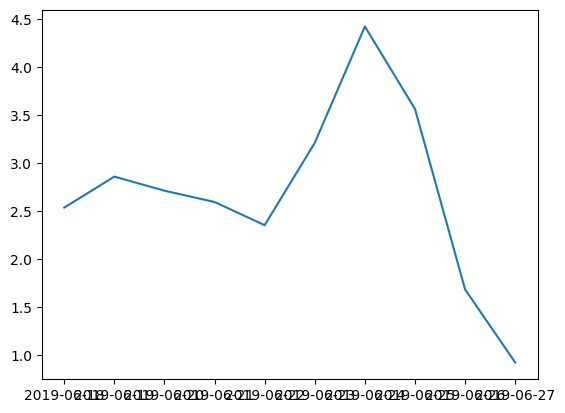

In [140]:
plt.plot(g)